<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Recommender%20Systems/Emb_based_RecSys_PyTorch/lesson4_collab_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [15]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [6]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [10]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.608336,0.926222,00:00
1,0.847243,0.674648,00:00
2,0.651035,0.668199,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [19]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2019-09-13 11:04:18--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   793KB/s    in 1.2s    

2019-09-13 11:04:20 (793 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [20]:
!unzip /content/ml-latest-small.zip

Archive:  /content/ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [21]:
ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [23]:
movies = pd.read_csv('/content/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
len(ratings)

100836

In [25]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [27]:
data.show_batch()

userId,title,target
78,Iron Man (2008),3.0
268,Besieged (a.k.a. L' Assedio) (1998),3.0
360,Dante's Peak (1997),2.0
466,Spider-Man 3 (2007),3.5
599,Dead or Alive: Final (2002),1.5


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


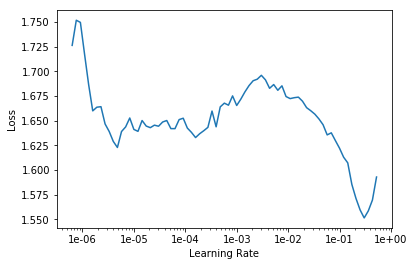

In [30]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [31]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.826642,0.789412,00:08
1,0.748237,0.725284,00:08
2,0.618069,0.700696,00:08
3,0.467837,0.680338,00:08
4,0.369465,0.679766,00:08


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [34]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(611, 40)
  (i_weight): Embedding(9352, 40)
  (u_bias): Embedding(611, 1)
  (i_bias): Embedding(9352, 1)
)

In [35]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)',
       'Silence of the Lambs, The (1991)', 'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Jurassic Park (1993)', 'Braveheart (1995)', 'Terminator 2: Judgment Day (1991)', "Schindler's List (1993)"],
      dtype=object)

### Movie bias

In [36]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [52]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.2143), 'Free Willy (1993)', 2.391891891891892),
 (tensor(-0.2120), 'Godzilla (1998)', 1.9545454545454546),
 (tensor(-0.2010), 'I Know What You Did Last Summer (1997)', 2.109375),
 (tensor(-0.1948), 'Ace Ventura: When Nature Calls (1995)', 2.727272727272727),
 (tensor(-0.1836), 'Flintstones, The (1994)', 2.357142857142857),
 (tensor(-0.1715), 'Casper (1995)', 2.806451612903226),
 (tensor(-0.1675), 'Coneheads (1993)', 2.4206349206349205),
 (tensor(-0.1591), 'Lost World: Jurassic Park, The (1997)', 2.753731343283582),
 (tensor(-0.1574), 'Austin Powers in Goldmember (2002)', 2.8461538461538463),
 (tensor(-0.1523), 'Batman & Robin (1997)', 2.2142857142857144),
 (tensor(-0.1509), 'Showgirls (1995)', 2.4714285714285715),
 (tensor(-0.1463), 'Alice in Wonderland (2010)', 2.875),
 (tensor(-0.1461), 'Hollow Man (2000)', 2.2948717948717947),
 (tensor(-0.1450), 'Cable Guy, The (1996)', 2.8055555555555554),
 (tensor(-0.1420), 'Hulk (2003)', 2.5606060606060606)]

In [40]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.4966), 'Shawshank Redemption, The (1994)', 4.429022082018927),
 (tensor(0.4740), 'Forrest Gump (1994)', 4.164133738601824),
 (tensor(0.3712),
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
  4.2075),
 (tensor(0.3609), 'Intouchables (2011)', 4.108108108108108),
 (tensor(0.3595), 'Good Will Hunting (1997)', 4.078014184397163),
 (tensor(0.3479), 'Philadelphia Story, The (1940)', 4.310344827586207),
 (tensor(0.3460),
  'Star Wars: Episode IV - A New Hope (1977)',
  4.231075697211155),
 (tensor(0.3397), 'Up (2009)', 4.004761904761905),
 (tensor(0.3376), 'Dark Knight, The (2008)', 4.238255033557047),
 (tensor(0.3264), 'Usual Suspects, The (1995)', 4.237745098039215),
 (tensor(0.3262), 'Departed, The (2006)', 4.252336448598131),
 (tensor(0.3243), "One Flew Over the Cuckoo's Nest (1975)", 4.203007518796992),
 (tensor(0.3206), 'Goodfellas (1990)', 4.25),
 (tensor(0.3146), 'Shining, The (1980)', 4.08256880733945),
 (tensor(0.3143),
  'Eternal Sunsh

### Movie weights

In [41]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [42]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [44]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8117), 'Pulp Fiction (1994)'),
 (tensor(0.8025), 'Godfather, The (1972)'),
 (tensor(0.7742), 'Godfather: Part II, The (1974)'),
 (tensor(0.7245), '12 Angry Men (1957)'),
 (tensor(0.7241), "Schindler's List (1993)"),
 (tensor(0.7073), 'Memento (2000)'),
 (tensor(0.6989),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (tensor(0.6905), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(0.6798), 'Annie Hall (1977)'),
 (tensor(0.6722), 'Rear Window (1954)')]

In [45]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0248), 'Anaconda (1997)'),
 (tensor(-0.9621), 'Lara Croft: Tomb Raider (2001)'),
 (tensor(-0.9591), 'Flintstones, The (1994)'),
 (tensor(-0.9337), 'Congo (1995)'),
 (tensor(-0.9247), 'Wild Wild West (1999)'),
 (tensor(-0.9092), 'Striptease (1996)'),
 (tensor(-0.9022), "City Slickers II: The Legend of Curly's Gold (1994)"),
 (tensor(-0.8995), 'Under Siege 2: Dark Territory (1995)'),
 (tensor(-0.8721), 'Batman & Robin (1997)'),
 (tensor(-0.8717), 'Coyote Ugly (2000)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [47]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.7571), 'Showgirls (1995)'),
 (tensor(0.6758), 'Blue Velvet (1986)'),
 (tensor(0.6609), 'Mulholland Drive (2001)'),
 (tensor(0.6582), 'Eyes Wide Shut (1999)'),
 (tensor(0.6248), 'Tank Girl (1995)'),
 (tensor(0.6212), 'Natural Born Killers (1994)'),
 (tensor(0.5908), 'Election (1999)'),
 (tensor(0.5717), 'Blair Witch Project, The (1999)'),
 (tensor(0.5662), 'Carrie (1976)'),
 (tensor(0.5566), '13th Warrior, The (1999)')]

In [48]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.6346), 'Fugitive, The (1993)'),
 (tensor(-0.6292), 'Harry Potter and the Chamber of Secrets (2002)'),
 (tensor(-0.6127), 'Harry Potter and the Order of the Phoenix (2007)'),
 (tensor(-0.6091), 'Harry Potter and the Deathly Hallows: Part 1 (2010)'),
 (tensor(-0.6091), 'Harry Potter and the Half-Blood Prince (2009)'),
 (tensor(-0.6004), 'Remember the Titans (2000)'),
 (tensor(-0.5773), 'Beauty and the Beast (1991)'),
 (tensor(-0.5682), 'Princess Bride, The (1987)'),
 (tensor(-0.5645), 'Aladdin (1992)'),
 (tensor(-0.5571), 'Harry Potter and the Deathly Hallows: Part 2 (2011)')]

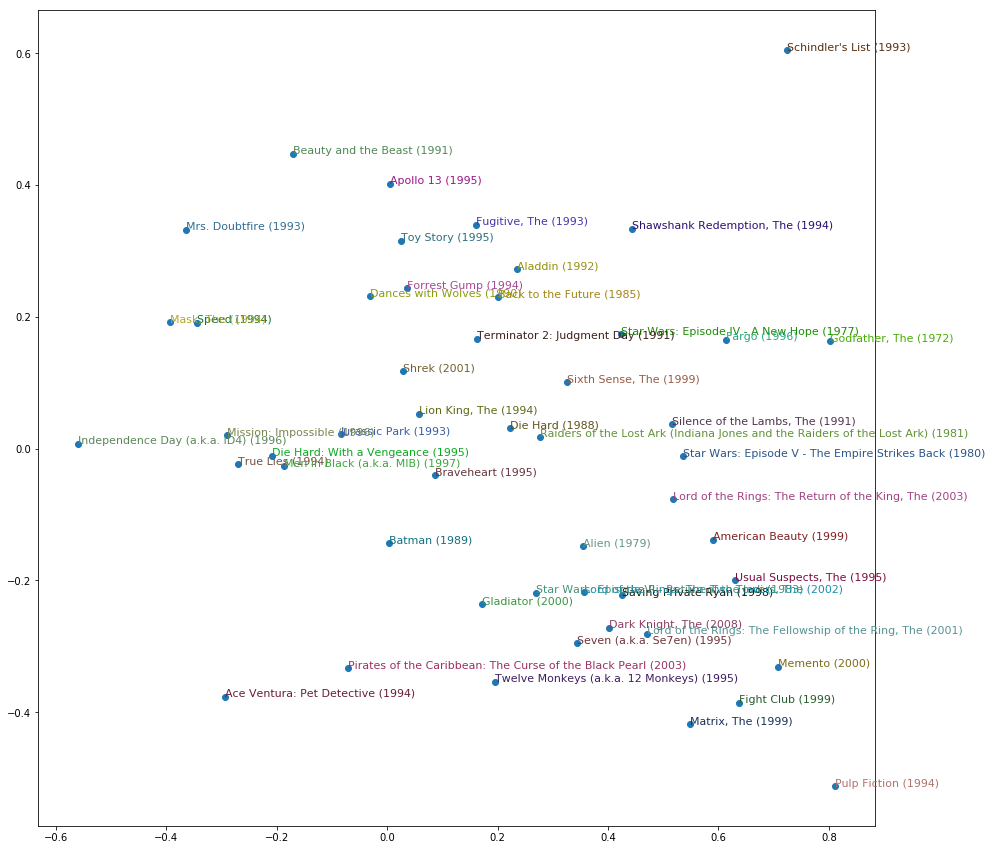

In [49]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()